In [1]:
import pandas as pd
from datetime import datetime, date
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
from pandas_profiling import ProfileReport

from lightgbm import LGBMRegressor, LGBMClassifier
from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit,
    plot_splits,
    print_cv_info,
    print_split_info,
)
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV

pd.options.display.max_rows = 40
pd.options.display.max_columns = None

# I. Javier Mermet

![](https://metadata.fundacionsadosky.org.ar/media/media/images/HOPP_-_Flyer_web_metadata.png)

En este notebook expongo mi resolución a la competencia `Series de tiempo en Hopp`, patrocinada por [Alix Partners](https://www.alixpartners.com) en el contexto de la [edición 35 de la ECI](https://eci.dc.uba.ar).

La competencia nos invita a predecir pagos de prestamos otorgados por _HOPP_. Tenemos data histórica de pagos y metadata de los préstamos otorgados. Para cada préstamo podemos tener varias fechas de pagos, lo cual le da una estructura de series de tiempo.

Trabajar con series de tiempo presenta algunas complejidades adicionales respecto a problemas tabulares, dado que tenemos grupos no independientes de datos con una secuencia temporal que no puede ser ignorada. La propuesta es:

- Analizar la data de un modo sencillo y hacer doble click donde fuera necesario
  - Al enfrentarse con un dominio desconocido, es útil tener todo el contexto. Sin embargo, algunos cruces avanzados se deben elaborar a fin de validar y testear hipotesis que puedan ayudar en el modelado.
- Utilizar un modelo lo más sencillo posible de entrenar.
  - Idealmente, un modelo que podamos explicar, ya sea desde su estructura o valores SHAP. Si bien esto no es pedido, es una práctica a la cual cada día se le presta más atención. En particular en ambientes de fintech, donde los estudios sobre fairness han cobrado mucha relevancia.
- Asegurarse de no utilizar features que filtren información.
  - Uno podría, por ejemplo, agregar como feature el promedio histórico de pagos. Sin embargo, esto podría estar filtrando información de pagos futuros a los pagos iniciales.
- Validar localmente mejoras en los modelos
  - Antes de hacer submits, idealmente quisiera poder comparar modelos localmente.
  - Más allá del contexto de la competencia, mi intención es seguir las mejores prácticas que me sean conocidas del área. De este modo, puedo entregar un pipeline robusto, extensible y claro.
- Aprender, divertirse, conocer
  - Este tipo de iniciativas son ideales para aprender nuevas herramientas, tecnologías o metodologías que quizás uno no pueda aplicar en el día a día. El leaderboard es una ruleta, pero aprender tiene cero riesgo.
  - Lo anterior no tiene sentido si genera estrés. Es una oportunidad donde no hay costos en entregar tarde o algo no tan performante. El camino debe ser disfrutable.
  - La competencia se acompaña de un slack donde los/las/les participantes se pueden sumar e intercambiar ideas. Es ideal el entorno para conocer más gente del ámbito y aprender juntos.
  
Dicho todo esto, veamos como llegamos a un resultado.

# Cargar y analizar datos

La etapa de `EDA` (Análisis exploratorio de datos) es la primer tarea a encarar en cualquier problema de Data Science/Machine learning. Como dije antes, mas cuando se desconoce el dominio.

Al no 

## Agency product name
>  Información sobre agencia que agrupa créditos, el tipo de crédito (PDL o BGL, payday loans o business growth loans, respectivamente).

```
AgencyId (Entero): ID de agencia (dependencia) de Hopp a la que pertenece el crédito.

ProductName (Categórica): Tipo de producto (PDL, BGL).

Country (Categórica): País de la operación.
```

In [2]:
df_agency = pd.read_csv("loan_agency_product_name.csv")
profile = ProfileReport(df_agency, title="Agency product name", minimal=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Funding Origination

> Información sobre a qué agencia pertenece cada crédito y la fecha de creación de cada crédito.

```
- LoanId (Entero): ID único del crédito.

- AgencyId (Entero): ID de agencia (dependencia) de Hopp a la que pertenece el crédito.

- FundingID (Entero): ID de la entidad financiadora.

- OriginationDate (Datetime): Fecha de originación del crédito.

- InstallmentAmount (Decimal): Valor del préstamo (valor de la cuota correspondiente = InstallmentAmount/Term).

- Periodicity (Categórica): Periodicidad del crédito.

- LoanOperationalStatus (Categórica): Estado operacional del crédito al fin del período (diciembre 2020).

- VAT (Entero): Porcentaje asignado al IVA.

- Term (Entero): Cantidad de plazos del crédito.
```

In [3]:
df_orig = pd.read_csv("loan_funding_origination_info.csv", parse_dates=["OriginationDate"])
df_orig.rename(inplace=True, columns={"InstallmentAmount":"LoanAmount"})
df_orig["InstallmentAmount"] = df_orig.LoanAmount / df_orig.Term

profile = ProfileReport(df_orig, title="Funding Origination", minimal=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/nox/repos/venv/lib64/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

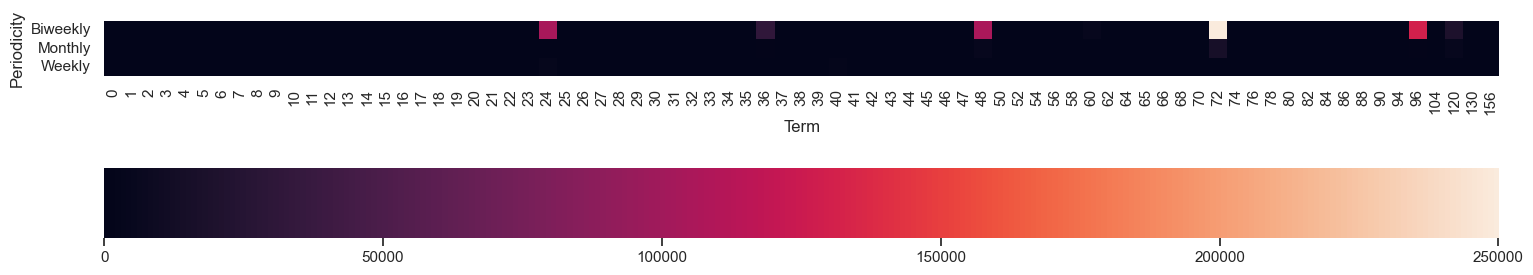

In [4]:
plt.figure(figsize=(18,8))
sns.heatmap(
    df_orig.pivot_table(index="Periodicity", columns="Term", values="LoanId", aggfunc="count", fill_value=0),
    square=True,
    cbar_kws={"orientation":"horizontal"},
)
plt.show()

## Payments
> Incluye pagos y dinámica histórica (desde 2019) de las operaciones de Hopp. La creación de créditos fue removida desde 2019 en adelante. Datos hasta junio 2020 inclusive.

```
LoanId (Entero): ID único del crédito.

PaymentId (Entero): ID único de cada pago.

PaymentSource (Categórica): Fuente de Pago (regular, contractor, alternative, additional).

PaymentType (Entero): Variable que clasifica distintos mecanismos de pago adicional.

PaymentTypeDescription (Categórica): Descripción de los mecanismos de pago adicional.

PaymentAmount (Decimal): Total pagado en el pago con PaymentId de la fila.

PaymentPrincipalAmount (Decimal): Parte del pago con PaymentId de la fila aplicado al saldo de principal.

PaymentInterestAmount (Decimal): Parte del pago con PaymentId de la fila aplicado al saldo de interés.

PaymentVATAmount (Decimal): Parte del pago con PaymentId de la fila aplicado al saldo de IVA.

PaymentDueDate (Datetime): Fecha de aplicación del pago procesado (no disponible para todas las PaymentSources).

PaymentTransferDate (Datetime): Fecha en que Hopp recibió la transferencia bancaria del pago indicado (no disponible para todas las PaymentSources).

PaymentProcessingDate (Datetime): Fecha en que Hopp procesó el pago indicado (disponible para todas las PaymentSources).
```

In [5]:
df_payments = pd.read_csv("loan_payments_dataset.csv", parse_dates=["PaymentProcessingDate", "PaymentTransferDate", "PaymentDueDate"])

profile = ProfileReport(df_payments, title="Payments", minimal=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
df_payments = df_payments.groupby(
    ["LoanId", "PaymentProcessingDate", "PaymentSource", "PaymentType"],
    dropna=False
).agg(
    {
        "PaymentTypeDescription": pd.Series.mode,
        "PaymentAmount": "sum",
        "PaymentPrincipal": "sum",
        "PaymentInterest": "sum",
        "PaymentVAT": "sum",
        "PaymentDueDate": "min",
        "PaymentTransferDate": "min",
    }
).reset_index().sort_values(["PaymentProcessingDate", "LoanId"])

<AxesSubplot:title={'center':'Difference between processing date and transfer date'}, xlabel='days', ylabel='count'>

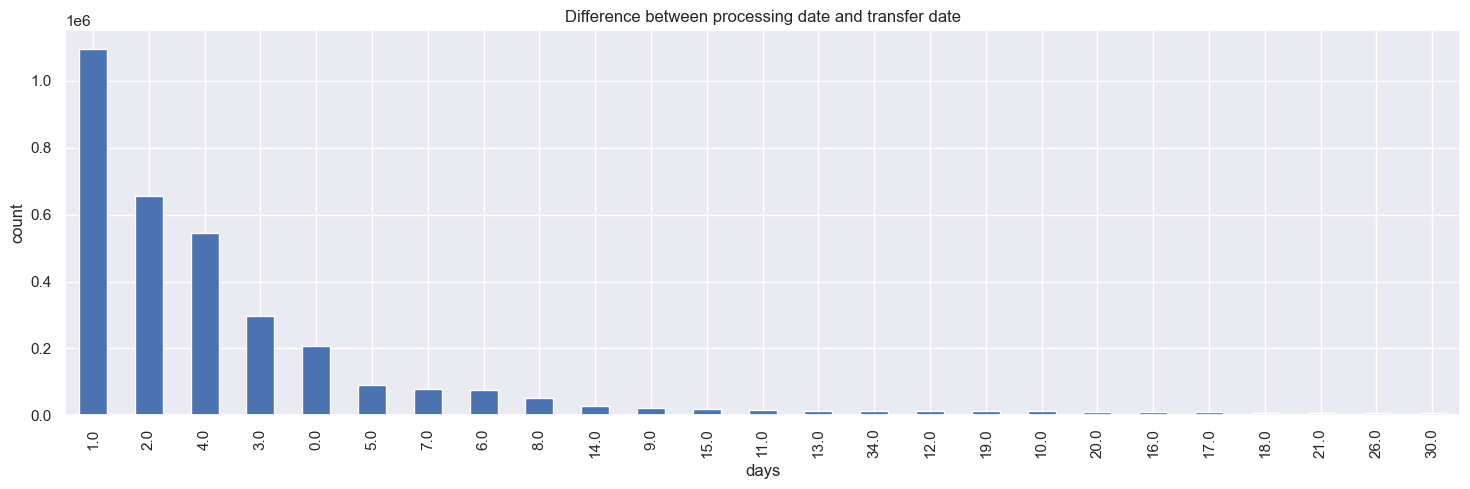

In [7]:
(df_payments.PaymentProcessingDate - df_payments.PaymentTransferDate).dt.days.value_counts().head(25).plot(
    kind="bar", title="Difference between processing date and transfer date",
    figsize=(18,5), xlabel="days", ylabel="count"
)

<AxesSubplot:title={'center':'Difference between payment due date and payment transfer date'}, xlabel='days', ylabel='count'>

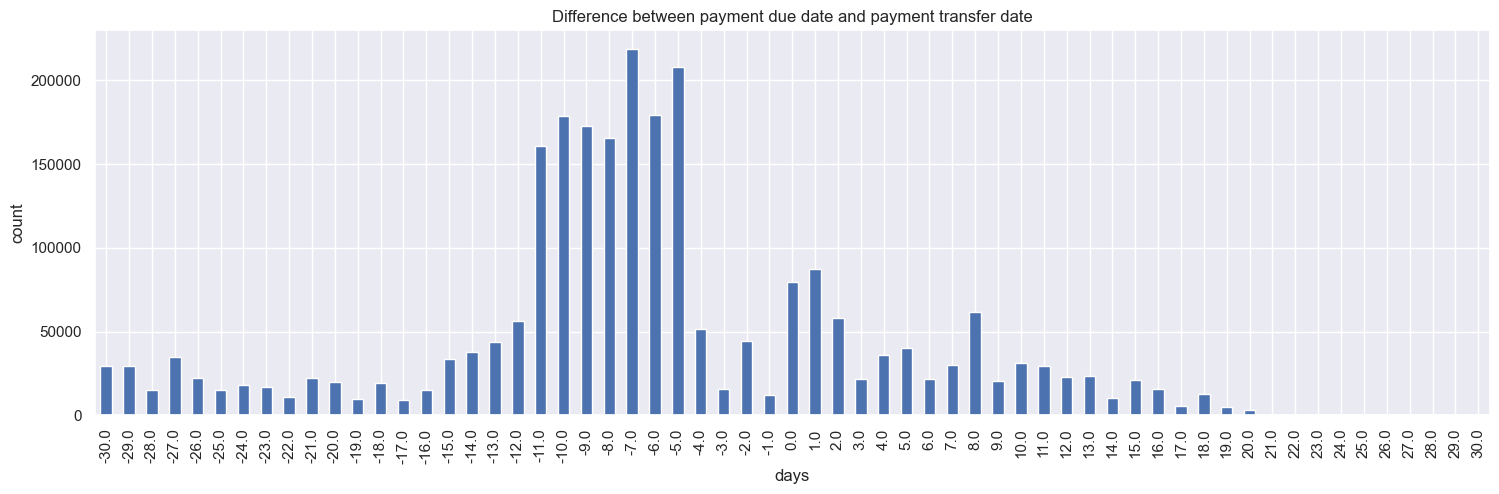

In [8]:
x = (df_payments[df_payments.PaymentDueDate.notna()].PaymentDueDate - df_payments[df_payments.PaymentDueDate.notna()].PaymentTransferDate).dt.days
x = x[x.between(-30, 30)].value_counts().sort_index()
x.plot(
    kind="bar", title="Difference between payment due date and payment transfer date", figsize=(18,5), xlabel="days", ylabel="count"
)

In [9]:
df_payments["DiffProcessingDateDueDate"] = (df_payments["PaymentProcessingDate"] - df_payments["PaymentDueDate"]).dt.days

/home/nox/repos/venv/lib64/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


<AxesSubplot:xlabel='DiffProcessingDateDueDate', ylabel='Density'>

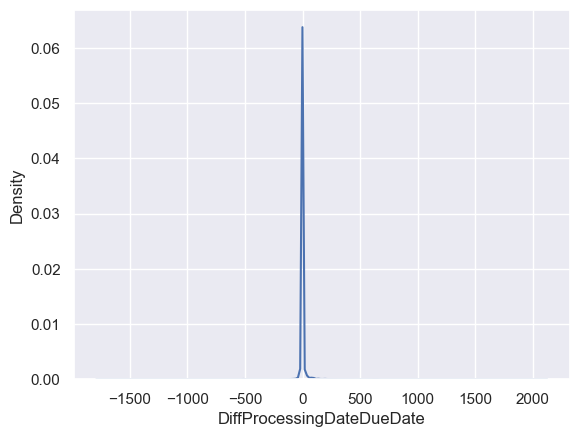

In [10]:
mean_diffdates = df_payments[df_payments.PaymentSource == "Regular"].sort_values("PaymentProcessingDate").groupby("LoanId").DiffProcessingDateDueDate.apply(np.diff).apply(np.mean)
sns.kdeplot(mean_diffdates)

In [11]:
mean_diffdates[mean_diffdates.between(-1,1)]

LoanId
3600      -0.133333
3846      -0.680000
3880      -0.680000
3881      -0.680000
3900      -0.680000
             ...   
9417746    0.823529
9417747    0.000000
9417748   -0.565217
9417749    0.000000
9417757    0.062500
Name: DiffProcessingDateDueDate, Length: 94452, dtype: float64

In [12]:
df_payments[df_payments.PaymentPrincipal > 0].LoanId.value_counts().head()

9182144    47
9176719    47
9416013    47
9405682    47
9379384    47
Name: LoanId, dtype: int64

<AxesSubplot:>

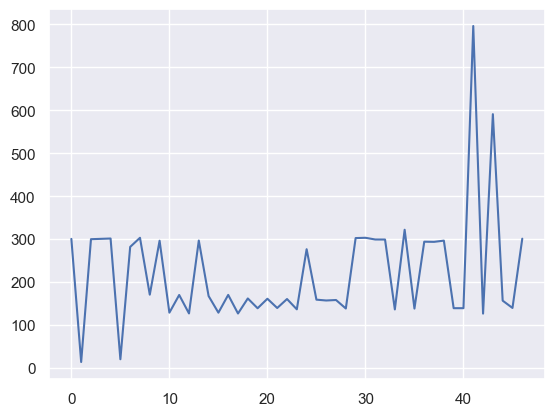

In [13]:
df_payments[(df_payments.PaymentPrincipal > 0) & (df_payments.LoanId == 9344259)].sort_values("PaymentProcessingDate").PaymentPrincipal.reset_index(drop=True).plot()

In [14]:
len(df_payments)

3382183

## Indexed dataset
> Información de tipo de indexación de cada crédito en el portafolio.

```
LoanId (Entero): ID único del crédito.

ProductName (Categórica): Tipo de producto (PDL, BGL).

Type (Categórica): Variable que indica si el crédito está indexado (Base, D-Indexed).

D-IndexedTo (Categórica): Variable que indica a quién indexa el crédito (Hopp, Zoltan, Ringu, Freeman).
```

In [15]:
df_dindex = pd.read_csv("loan_dindexedto_dataset.csv")

profile = ProfileReport(df_dindex, title="Indexed to", minimal=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Predictions sample
> Template con los préstamos y fechas a predecir.

In [62]:
predictions_sample = pd.read_csv("loan_payments_dataset_scoring.csv", names=["PaymentCode", "PaymentPrincipal"], dtype={
    "PaymentCode": str,
    "PaymentPrincipal": float
})

predictions_sample = predictions_sample.join(predictions_sample.PaymentCode.astype(str).str.extract(r'^(?P<PaymentSource>\d{2})(?P<Date>\d{6})(?P<LoanId>.*)'))

predictions_sample.LoanId = predictions_sample.LoanId.astype(int)
predictions_sample.PaymentSource = predictions_sample.PaymentSource.astype(int)
# predictions_sample.PaymentTypeId = predictions_sample.PaymentTypeId.astype(int)

predictions_sample.Date = pd.to_datetime(predictions_sample.Date, format="%y%m%d").dt.date

predictions_sample["PaymentType"] = predictions_sample.PaymentSource.apply(lambda x: x if x not in (0,1,2) else None)

predictions_sample.PaymentSource = predictions_sample.PaymentSource.map({
    0: "Regular",
    1: "Alternative",
    2: "Contractor"
}).fillna("Additional")

In [63]:
predictions_sample.head()

PaymentCode  PaymentPrincipal PaymentSource        Date   LoanId  \
0  022102049402357               NaN    Contractor  2021-02-04  9402357   
1   00201030668519               NaN       Regular  2020-10-30   668519   
2  002011249339435               NaN       Regular  2020-11-24  9339435   
3  002104209148631               NaN       Regular  2021-04-20  9148631   
4   00210607131505               NaN       Regular  2021-06-07   131505   

   PaymentType  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [64]:
orig_loanids = set(df_orig.LoanId.unique())
predictions_loanids = set(predictions_sample.LoanId.unique())
print(f"All predictions in payments? {(orig_loanids & predictions_loanids) == predictions_loanids}. Diff: {len(predictions_loanids - orig_loanids)}")

All predictions in payments? False. Diff: 5


In [65]:
predictions_sample[~predictions_sample.LoanId.isin(df_orig.LoanId)]

PaymentCode  PaymentPrincipal PaymentSource        Date  LoanId  \
7928     002110295405               NaN       Regular  2021-10-29    5405   
50127    002112285406               NaN       Regular  2021-12-28    5406   
944338   002110225404               NaN       Regular  2021-10-22    5404   
1109375  002112305409               NaN       Regular  2021-12-30    5409   
1116352  002107205403               NaN       Regular  2021-07-20    5403   
1220610  002107235403               NaN       Regular  2021-07-23    5403   

         PaymentType  
7928             NaN  
50127            NaN  
944338           NaN  
1109375          NaN  
1116352          NaN  
1220610          NaN

In [66]:
cheats = {
"002107235403":1474,
"002107205403":1474,
"002110225404":591,
"002110295405":488,
"002112285406":1247,
"002112305409":1253
}

In [67]:
loan_ids_to_predict = predictions_sample.LoanId.unique()

<AxesSubplot:>

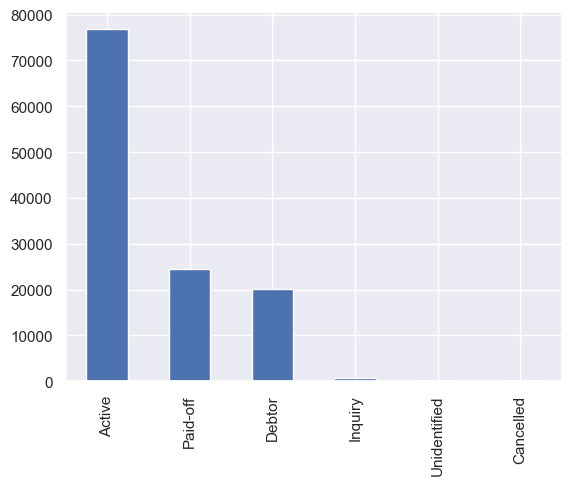

In [68]:
df_orig[df_orig.LoanId.isin(loan_ids_to_predict)].LoanOperationalStatus.value_counts().plot(kind="bar")

In [69]:
predictions_sample.LoanId.value_counts()

653139     64
9361293    64
9275791    59
9343898    59
9359087    59
           ..
9143458     1
9145866     1
519749      1
9279168     1
9153809     1
Name: LoanId, Length: 122351, dtype: int64

# Cross reference payments and origin

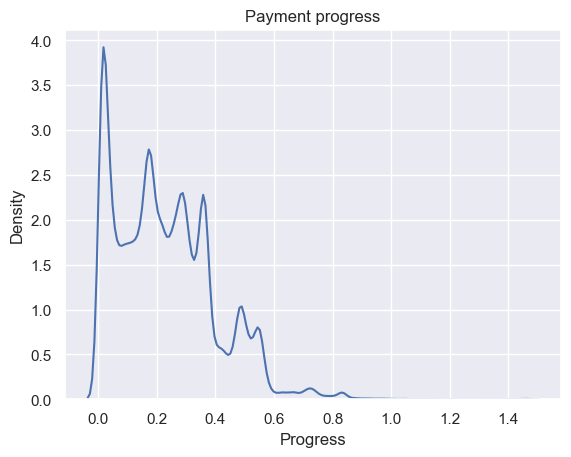

In [24]:
df = df_orig.merge(
    df_payments.LoanId.value_counts().rename("PaymentsRegistered"),
    left_on="LoanId",
    right_index=True
)
df["Progress"] = df.PaymentsRegistered / df.Term
sns.kdeplot(df[np.isfinite(df.Progress)].Progress)
plt.title("Payment progress")
plt.show()

# Do we need to predict for wanky loans?

In [25]:
predictions_sample.LoanId.isin(
    df_orig[df_orig.Term == 0].LoanId
).nunique()

2

# Orient data

In [26]:
df = pd.merge(df_payments, df_orig, left_on="LoanId", right_on="LoanId", how="left")
df = df.merge(df_dindex, left_on="LoanId", right_on="LoanId", how="left")

In [27]:
df["WasOnTime"] = (df.PaymentProcessingDate <= df.PaymentDueDate)
df["Lateness"] = (df.PaymentProcessingDate - df.PaymentDueDate).dt.days
df["WasLate"] = (df.PaymentProcessingDate - df.PaymentDueDate).dt.days > 15
df["WasReallyLate"] = (df.PaymentProcessingDate - df.PaymentDueDate).dt.days > 30
df["WasReallyReallyLate"] = (df.PaymentProcessingDate - df.PaymentDueDate).dt.days > 90

df = df.sort_values(by=["LoanId", "PaymentSource", "PaymentType", "PaymentProcessingDate"]).reset_index(drop=True)

In [28]:
print(len(df))

3382183


In [29]:
df["LoanProp"] = df.PaymentPrincipal / df.LoanAmount

x = df.groupby(
        ["LoanId", "PaymentSource", "PaymentType"], dropna=False
    ).expanding().LoanProp.agg(
        ["mean", "min", "max", "median"]
    ).reset_index(
        drop=False,
        level=["LoanId", "PaymentSource", "PaymentType"]
    ).groupby(
        ["LoanId", "PaymentSource", "PaymentType"], dropna=False
    ).shift(1).add_prefix("LoanProp_")

df.drop(columns=["LoanProp"], inplace=True)

In [30]:
z = df.groupby(
        ["LoanId", "PaymentSource", "PaymentType"], dropna=False
    ).expanding().PaymentPrincipal.agg(
        ["mean", "min", "max", "median"]
    ).reset_index(
        drop=False,
        level=["LoanId", "PaymentSource", "PaymentType"]
    ).groupby(
        ["LoanId", "PaymentSource", "PaymentType"], dropna=False
    ).shift(1).add_prefix("PaymentPrincipal_")

In [31]:
w = df.groupby(
        ["LoanId", "PaymentSource", "PaymentType"], dropna=False
    ).expanding()[
        ["WasOnTime", "Lateness", "WasLate", "WasReallyLate", "WasReallyReallyLate"]
    ].agg(
        "mean"
    ).reset_index(
        drop=False,
        level=["LoanId", "PaymentSource", "PaymentType"]
    ).groupby(
        ["LoanId", "PaymentSource", "PaymentType"], dropna=False
    ).shift(1).add_suffix("_mean")

In [32]:
df = df.join(
    x,
    how='inner'
)

In [33]:
# Time lagged variables

df = df.join(
    z,
    how='inner'
)

In [34]:
df = df.join(
    w,
    how='inner'
)

In [35]:
len(df)

3382183

In [36]:
df["IsZero___"] = df.PaymentPrincipal == 0

In [37]:
df.head(3)

LoanId PaymentProcessingDate PaymentSource  PaymentType  \
0     303            2020-01-06    Contractor          NaN   
1    1326            2020-01-06    Contractor          NaN   
2    1763            2020-01-06    Contractor          NaN   

  PaymentTypeDescription  PaymentAmount  PaymentPrincipal  PaymentInterest  \
0                     []           0.53              0.53              0.0   
1                     []          20.00             20.00              0.0   
2                     []         500.00            500.00              0.0   

   PaymentVAT PaymentDueDate PaymentTransferDate  DiffProcessingDateDueDate  \
0         0.0            NaT          2019-12-31                        NaN   
1         0.0            NaT          2019-12-31                        NaN   
2         0.0            NaT          2019-12-31                        NaN   

   AgencyId  FundingID OriginationDate  LoanAmount Periodicity  \
0       100          6      2008-10-02      8036.0    Biweekly   
1       300          6      2008-03-16         0.0    Biweekly   
2       183          6      2008-10-02      3888.0    Biweekly   

  LoanOperationalStatus  VAT  Term  InstallmentAmount ProductName  Type  \
0              Paid-off   15    41              196.0         PDL  Base   
1             Cancelled   15    48                0.0         PDL  Base   
2              Paid-off   15    27              144.0         PDL  Base   

  D-IndexedTo  WasOnTime  Lateness  WasLate  WasReallyLate  \
0        Hopp      False       NaN    False          False   
1        Hopp      False       NaN    False          False   
2        Hopp      False       NaN    False          False   

   WasReallyReallyLate  LoanProp_mean  LoanProp_min  LoanProp_max  \
0                False            NaN           NaN           NaN   
1                False            NaN           NaN           NaN   
2                False            NaN           NaN           NaN   

   LoanProp_median  PaymentPrincipal_mean  PaymentPrincipal_min  \
0              NaN                    NaN                   NaN   
1              NaN                    NaN                   NaN   
2              NaN                    NaN                   NaN   

   PaymentPrincipal_max  PaymentPrincipal_median  WasOnTime_mean  \
0                   NaN                      NaN             NaN   
1                   NaN                      NaN             NaN   
2                   NaN                      NaN             NaN   

   Lateness_mean  WasLate_mean  WasReallyLate_mean  WasReallyReallyLate_mean  \
0            NaN           NaN                 NaN                       NaN   
1            NaN           NaN                 NaN                       NaN   
2            NaN           NaN                 NaN                       NaN   

   IsZero___  
0      False  
1      False  
2      False

In [38]:
(df.PaymentPrincipal == 0).mean()

0.4896846208499067

In [39]:
#nzpayments = df[df.PaymentPrincipal != 0][["LoanId", "PaymentPrincipal", "PaymentProcessingDate"]].rename(
#    columns={"PaymentProcessingDate":"LastNonZeroPaymentProcessingDate", "PaymentPrincipal": "LastNonZeroPaymentPrincipal"}
#)
#df = pd.merge_asof(df, nzpayments, left_on="PaymentProcessingDate", right_on="LastNonZeroPaymentProcessingDate", by="LoanId", direction="backward", allow_exact_matches=False)

# = df.sort_values(
#        ["LoanId", "PaymentProcessingDate"]
#    ).groupby("LoanId").expanding().PaymentPrincipal.agg([fit_lr_i, fit_lr_c])

#ppa = df_payments[(df_payments.PaymentPrincipal > 0)].groupby("LoanId").PaymentPrincipal.agg(["mean", "median"]).rename(
#    columns={"mean":"PaymentPrincipalMean", "median":"PaymentPrincipalMedian"}
#)
#df = df.merge(ppa, on="LoanId", how="left")

#df = df.join(aggs.droplevel("LoanId"))
#df.rename(
#    columns={"fit_lr_i": "ridge_intercept", "fit_lr_c": "ridge_coef_0"},
#    inplace=True
#)

# df = df.merge(coefs, on="LoanId", how="left")
# df["ridge_coef_0"] = r_coefs
# df["ridge_intercept"] = r_intercepts

#df["DaysSincePreviousNonZeroPayment"] = (df.PaymentProcessingDate - df.LastNonZeroPaymentProcessingDate).dt.days

#df["WasOnTime"] = (df.PaymentProcessingDate <= df.PaymentDueDate)
#df["PropOnTime"] = df.groupby

#df["WasLate"] = (df.PaymentProcessingDate - df.PaymentDueDate).dt.days > 15
#df["WasReallyLate"] = (df.PaymentProcessingDate - df.PaymentDueDate).dt.days > 30
#df["WasReallyReallyLate"] = (df.PaymentProcessingDate - df.PaymentDueDate).dt.days > 90
#df["WasReallyReallyReallyLate"] = (df.PaymentProcessingDate - df.PaymentDueDate).dt.days > 180

#df["WasEverLate"] = df.groupby("LoanId").WasLate.cumsum()# > 0
#df["WasEverReallyLate"] = df.groupby("LoanId").WasReallyLate.cumsum()# > 0
#df["WasEverReallyReallyLate"] = df.groupby("LoanId").WasReallyReallyLate.cumsum()# > 0
#df["WasEverReallyReallyReallyLate"] = df.groupby("LoanId").WasReallyReallyReallyLate.cumsum()# > 0

#df["AccumulatedPrincipals"] = df.groupby("LoanId").PaymentPrincipal.cumsum()
#df["PrincipalPaidOff"] = df.AccumulatedPrincipals >= df.LoanAmount
#df["PrincipalPaidOffProportion"] = df.AccumulatedPrincipals / df.LoanAmount

In [40]:
#df["InstallmentProportion"] = df.PaymentPrincipal / df.InstallmentAmount
#
#df = pd.merge_asof(
#    df,
#    df[["LoanId", "PaymentProcessingDate", "InstallmentProportion"]].rename(columns={"InstallmentProportion":"LastInstallmentProportion"}),
#    left_on="PaymentProcessingDate", right_on="PaymentProcessingDate", by="LoanId", direction="backward", allow_exact_matches=False
#)

df["WeeksSinceOrigination"] = (df.PaymentProcessingDate - df.OriginationDate).dt.days // 7

In [41]:
df.columns

Index(['LoanId', 'PaymentProcessingDate', 'PaymentSource', 'PaymentType',
       'PaymentTypeDescription', 'PaymentAmount', 'PaymentPrincipal',
       'PaymentInterest', 'PaymentVAT', 'PaymentDueDate',
       'PaymentTransferDate', 'DiffProcessingDateDueDate', 'AgencyId',
       'FundingID', 'OriginationDate', 'LoanAmount', 'Periodicity',
       'LoanOperationalStatus', 'VAT', 'Term', 'InstallmentAmount',
       'ProductName', 'Type', 'D-IndexedTo', 'WasOnTime', 'Lateness',
       'WasLate', 'WasReallyLate', 'WasReallyReallyLate', 'LoanProp_mean',
       'LoanProp_min', 'LoanProp_max', 'LoanProp_median',
       'PaymentPrincipal_mean', 'PaymentPrincipal_min', 'PaymentPrincipal_max',
       'PaymentPrincipal_median', 'WasOnTime_mean', 'Lateness_mean',
       'WasLate_mean', 'WasReallyLate_mean', 'WasReallyReallyLate_mean',
       'IsZero___', 'WeeksSinceOrigination'],
      dtype='object')

In [42]:
categories = [
    "PaymentSource","PaymentType", "AgencyId", "FundingID", "Periodicity",
    "LoanOperationalStatus", "VAT", "Term", "ProductName", "Type", "D-IndexedTo",
    "LoanId"
] #"LoanId"]
for category in categories:
    df[category] = df[category].astype("category")

In [43]:
train_columns = [
       'LoanId',
       'PaymentSource', 'PaymentType',
       #'DiffProcessingDateDueDate',
       'AgencyId',
       'FundingID',
       'LoanAmount',
       'Periodicity',
       'LoanOperationalStatus', 'VAT', 'Term',
       'InstallmentAmount',
       'ProductName', 'Type', 'D-IndexedTo',
        #'WasOnTime', 'Lateness', 'WasLate', 'WasReallyLate', 'WasReallyReallyLate',
       'PaymentPrincipal_mean', 'PaymentPrincipal_min', 'PaymentPrincipal_max','PaymentPrincipal_median',
       #'LoanProp_mean', 'LoanProp_min', 'LoanProp_max','LoanProp_median',
       #'WasOnTime_mean', 'Lateness_mean', 'WasLate_mean', 'WasReallyLate_mean', 'WasReallyReallyLate_mean',
       #'IsZero___',
       #'MonthsSinceOrigination',
       #'WeeksSinceOrigination'
]

In [44]:
train_df = df[(df.PaymentAmount >= 0) & (df.LoanAmount > 0) & (df.PaymentPrincipal >= 0) & (df.PaymentInterest >= 0)]

In [45]:
total_rows = len(train_df)

holdouts = []
for _ in range(5):
    dups = train_df.duplicated(subset=["LoanId"], keep="last")
    holdouts.append(train_df[~dups])
    train_df = train_df[dups]
    
holdout_df = pd.concat(holdouts)

assert len(holdout_df) + len(train_df) == total_rows

In [46]:
train_df_additional = train_df[train_df.PaymentSource == "Additional"]
train_df_alternative = train_df[train_df.PaymentSource == "Alternative"]
train_df_contractor = train_df[train_df.PaymentSource == "Contractor"]
train_df = train_df[train_df.PaymentSource == "Regular"]
#train_df = train_df.drop(index=train_df_additional.index)

In [47]:
#loans = train_df.LoanId.value_counts()
#loans = loans[loans > 0]
#len(loans)

In [48]:
#train_df = train_df[train_df.LoanId.isin(loans.index)]

In [49]:
train_df_additional = train_df_additional.sort_values(["LoanId", "PaymentProcessingDate"])
train_df_alternative = train_df_alternative.sort_values(["LoanId", "PaymentProcessingDate"])
train_df_contractor = train_df_contractor.sort_values(["LoanId", "PaymentProcessingDate"])
train_df = train_df.sort_values(["LoanId", "PaymentProcessingDate"])

In [50]:
#train_df.PaymentType = df.PaymentType.astype(str)
#train_df.fillna({"PaymentType":"Nada"}).groupby(["PaymentSource", "PaymentType"], dropna=False).PaymentPrincipal.describe()

In [51]:
#train_df.drop(index=holdout_df.index, inplace=True)

In [52]:
models = {}

for payment_source, traindf in [
    ("Additional", train_df_additional),
    ("Alternative", train_df_alternative),
    ("Contractor", train_df_contractor),
    ("Regular", train_df)
]:
    groups = LabelEncoder().fit_transform(traindf.LoanId)

    y = traindf.PaymentPrincipal # InstallmentProportion
    X = traindf[train_columns]
    
    cv_args = {"test_size": 100, "n_splits": 3}
    cv = GroupTimeSeriesSplit(**cv_args)
    _ = [_ for _ in cv.split(X, y, groups=groups)]
    cv.get_n_splits()
    
    reg = LGBMRegressor()

    gscv = GridSearchCV(
        reg,
        param_grid={
            'boosting_type':['gbdt'],#, 'dart', 'goss', 'rf'],
            "max_bin": [4096],
            "silent":[False],
            "n_estimators":[100],#[10,25,50,100],
            "learning_rate":[0.1, 0.5],
            "metric":["mae"],
            #"enable_categorical":[True]
            "force_row_wise":[True],
            "importance_type":["split"],
            "num_leaves": [31]
        },
        n_jobs=1,
        refit=True,
        cv=cv,
        verbose=2,
        #scoring=mae_mae,
        scoring="neg_mean_absolute_error",
    )
    fit_reg = gscv.fit(X, y, groups=groups)
    models[payment_source] = gscv
    
    print(gscv.best_score_)
    
    print(gscv.best_params_)
    
    print(sorted(
        list(
            zip(
                gscv.best_estimator_.feature_name_,
                gscv.best_estimator_.feature_importances_
            )
        ),
        key=lambda x: x[1]
    ))
    
    holdout_df.loc[
        holdout_df.PaymentSource == traindf.PaymentSource.unique()[0],
        "pred"] = gscv.predict(
                        holdout_df.loc[holdout_df.PaymentSource == traindf.PaymentSource.unique()[0], train_columns]
    )

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[LightGBM] [Info] Total Bins 3481
[LightGBM] [Info] Number of data points in the train set: 14045, number of used features: 9
[LightGBM] [Info] Start training from score 28212.109101
[CV] END boosting_type=gbdt, force_row_wise=True, importance_type=split, learning_rate=0.1, max_bin=4096, metric=mae, n_estimators=100, num_leaves=31, silent=False; total time=   6.4s
[LightGBM] [Info] Total Bins 3481
[LightGBM] [Info] Number of data points in the train set: 14045, number of used features: 9
[LightGBM] [Info] Start training from score 28211.910580
[CV] END boosting_type=gbdt, force_row_wise=True, importance_type=split, learning_rate=0.1, max_bin=4096, metric=mae, n_estimators=100, num_leaves=31, silent=False; total time=   9.2s
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 14046, number of used features: 9
[LightGBM] [Info] Start training from score 28209.492813
[CV] END boosting_type=g

In [54]:
from sklearn.metrics import mean_absolute_error as MAE

In [55]:
MAE(holdout_df.PaymentPrincipal, holdout_df.pred)

284.42262418439

# Predict

In [70]:
pred = pd.merge(predictions_sample, df_orig, left_on="LoanId", right_on="LoanId", how="left").rename(columns={"Date": "PaymentProcessingDate"}).sort_values(["PaymentProcessingDate", "LoanId"])
pred = pred.merge(df_dindex, left_on="LoanId", right_on="LoanId", how="left")

df.PaymentSource = df.PaymentSource.astype(str)
df.PaymentType = df.PaymentType.astype(float)
df.LoanId = df.LoanId.astype(int)
last_aggs = df.groupby(
        ["LoanId", "PaymentSource", "PaymentType"], dropna=False
    ).PaymentPrincipal.agg(
        ["mean", "min", "max", "median"]
    ).add_prefix(
        "PaymentPrincipal_"
    ).reset_index(
        drop=False,
        level=["LoanId", "PaymentSource", "PaymentType"]
    )

pred = pred.merge(
    last_aggs,
    on=["LoanId", "PaymentSource", "PaymentType"],
    how="left"
)

In [71]:
categories = [
    "PaymentSource","PaymentType", "AgencyId", "FundingID", "Periodicity",
    "LoanOperationalStatus", "VAT", "Term", "ProductName", "Type", "D-IndexedTo",
    "LoanId"
] #"LoanId"]
for category in categories:
    pred[category] = pred[category].astype("category")

In [72]:
pred.PaymentSource.value_counts()

Regular        1714506
Contractor       95290
Alternative      35559
Additional        3034
Name: PaymentSource, dtype: int64

In [73]:
for payment_source, model in models.items():
    print(payment_source, len(pred[pred.PaymentSource == payment_source]))
    pred.loc[pred.PaymentSource == payment_source, "PaymentPrincipal"] = model.predict(
        pred.loc[pred.PaymentSource == payment_source, train_columns]
    )

Additional 3034
Alternative 35559
Contractor 95290
Regular 1714506


In [74]:
pred["PaymentPrincipal"] = (pred.PaymentPrincipal * (pred.PaymentPrincipal >= 0)).abs()

In [75]:
for k, v in cheats.items():
    pred.loc[pred.PaymentCode == k, "PaymentPrincipal"] = v

In [76]:
pred.PaymentPrincipal.isna().any()

False

In [77]:
pred[["PaymentCode", "PaymentPrincipal"]].to_csv("fixes.csv", header=False, index=False)

In [78]:
!head -n20 fixes.csv

13200701671045,0.0
08200701671045,9388.18478834366
082007019167594,5517.911812391258
132007019167594,22.267596824694277
082007019340648,9107.652722733865
132007019340648,458.63791749921216
132007019357922,0.0
082007019357922,15356.185952233553
132007019360821,0.0
082007019360821,24691.114030067012
132007019379876,116.67223827837826
082007019379876,10281.655172702633
082007019391054,3696.919314744051
132007019391054,0.0
132007019402678,58.80883064099237
082007019402678,3710.8809322419193
082007019404027,5362.292897167478
132007019404027,108.95635999105548
132007019406976,75.63052415829976
082007019406976,3130.9967882622423


In [79]:
len(pred), len(predictions_sample)

(1848389, 1848389)

In [80]:
raise ValueError()

ValueError: 

In [ ]:
y_holdout = holdout_df.PaymentPrincipal
X_holdout = holdout_df[train_columns]

In [ ]:
#(y >= 0).mean()

In [ ]:
cv_args = {"test_size": 100, "n_splits": 3}
cv = GroupTimeSeriesSplit(**cv_args)
_ = [_ for _ in cv.split(X, y, groups=groups)]
cv.get_n_splits()

In [ ]:
from xgboost import XGBRegressor


In [ ]:
class MAE_MAE:
    def __init__(self, full_df):
        self.full_df = full_df

    def __call__(self, est, X, y):
        y_pred = est.predict(X)
        _df = pd.DataFrame({"y":y, "yhat":y_pred,}, index=X.index).join(self.full_df)
        _df["err"] = (_df.y - _df.yhat).abs()
        return - _df.groupby("LoanId").err.agg("mean").mean()

mae_mae = MAE_MAE(df["LoanId"].copy())

reg = LGBMRegressor()
# reg = XGBRegressor()
#cross_val_score(reg, X, y, groups=groups, cv=cv).mean()
gscv = GridSearchCV(
    reg,
    param_grid={
        'boosting_type':['gbdt'],#, 'dart', 'goss', 'rf'],
        "max_bin": [4096],
        "silent":[False],
        "n_estimators":[100],#[10,25,50,100],
        "learning_rate":[0.1, 0.5],
        "metric":["mae"],
        #"enable_categorical":[True]
        "force_row_wise":[True],
        "importance_type":["split"],
        "num_leaves": [31]
    },
    n_jobs=1,
    refit=True,
    cv=cv,
    verbose=2,
    #scoring=mae_mae,
    scoring="neg_mean_absolute_error",
)
fit_reg = gscv.fit(X, y, groups=groups)
gscv.best_score_

In [ ]:
#import sklearn
#sklearn.metrics.get_scorer_names()

In [ ]:
gscv.best_params_

In [ ]:
sorted(
    list(
        zip(
            gscv.best_estimator_.feature_name_,
            gscv.best_estimator_.feature_importances_
        )
    ),
    key=lambda x: x[1]
)

In [ ]:
X_holdout_pred = gscv.predict(X_holdout)
print((X_holdout_pred >= 0).mean())

In [ ]:
clipped_X_holdout_pred = np.abs(X_holdout_pred * (X_holdout_pred >= 0))

In [ ]:
print(MAE(y_holdout, X_holdout_pred))
print(MAE(y_holdout, clipped_X_holdout_pred))
print(MAE(y_holdout, clipped_X_holdout_pred.round(2)))

In [ ]:
holdout_df["pred"] = clipped_X_holdout_pred

In [ ]:
holdout_df["ae"] = (holdout_df.pred - holdout_df.PaymentPrincipal)

In [ ]:
holdout_df["ae"].plot(kind="hist", bins=100, logy=True)

In [ ]:
#from sklearn.tree import DecisionTreeClassifier

clf = LGBMClassifier()
clf.fit(holdout_df[train_columns], holdout_df.ae_above_10k)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(holdout_df.ae_above_10k, clf.predict(holdout_df[train_columns])))

In [ ]:
holdout_df.sort_values("ae").tail(20)

In [ ]:
holdout_df[holdout_df.LoanId == 598609]

# Predict for all 

In [ ]:
print(f"1 - {len(predictions_sample)}")

pred = pd.merge(predictions_sample, df_orig, left_on="LoanId", right_on="LoanId", how="left").rename(columns={"Date": "PaymentProcessingDate"}).sort_values(["PaymentProcessingDate", "LoanId"])
pred = pred.merge(df_dindex, left_on="LoanId", right_on="LoanId", how="left")

print(f"2 - {len(pred)}")

pred.LoanId = pred.LoanId.astype(int)
pred.PaymentProcessingDate = pd.to_datetime(pred.PaymentProcessingDate)

print(f"3 - {len(pred)}")

#pred = pred.merge(coefs, on="LoanId", how="left")
pred = pred.merge(ppa, on="LoanId", how="left")

print(f"4 - {len(pred)}")

pred = pred.merge(
    df[["WasEverLate", "WasEverReallyLate", "WasEverReallyReallyLate", "WasEverReallyReallyReallyLate", "LoanId"]].drop_duplicates(subset=["LoanId"], keep="last"),
    on="LoanId", how="left")

print(f"5 - {len(pred)}")

pred.WasEverLate = pred.WasEverLate.astype(bool)
pred.WasEverReallyLate = pred.WasEverReallyLate.astype(bool)
pred.WasEverReallyReallyLate = pred.WasEverReallyReallyLate.astype(bool)
pred.WasEverReallyReallyReallyLate = pred.WasEverReallyReallyReallyLate.astype(bool)

pred["MonthsSinceOrigination"] = (pred.PaymentProcessingDate - pred.OriginationDate).dt.days / 30

print(f"6 - {len(pred)}")

categories = ["PaymentSource", "PaymentType", "AgencyId", "FundingID", "Periodicity", "LoanOperationalStatus", "VAT", "Term", "ProductName", "Type", "D-IndexedTo"]
for category in categories:
    pred[category] = pred[category].astype("category")

In [ ]:
gscv.predict(pred[train_columns])

# Predict one at a time

In [ ]:
import operator as ops

def merge_dicts(d1, d2, op=ops.add, neutral=0):
    merge =  {}
    keys = set(d1.keys())
    keys.update(set(d2.keys()))
    for key in keys:
        merge[key] = op(d1.get(key, neutral), d2.get(key, neutral))
    return merge

In [ ]:
print(f"1 - {len(predictions_sample)}")

pred = pd.merge(predictions_sample, df_orig, left_on="LoanId", right_on="LoanId", how="left").rename(columns={"Date": "PaymentProcessingDate"}).sort_values(["PaymentProcessingDate", "LoanId"])
pred = pred.merge(df_dindex, left_on="LoanId", right_on="LoanId", how="left")

print(f"2 - {len(pred)}")

pred.LoanId = pred.LoanId.astype(int)
pred.PaymentProcessingDate = pd.to_datetime(pred.PaymentProcessingDate)

print(f"3 - {len(pred)}")

#pred = pred.merge(coefs, on="LoanId", how="left")
pred = pred.merge(ppa, on="LoanId", how="left")

print(f"4 - {len(pred)}")

pred = pred.merge(
    df[["WasEverLate", "WasEverReallyLate", "WasEverReallyReallyLate", "WasEverReallyReallyReallyLate", "LoanId"]].drop_duplicates(subset=["LoanId"], keep="last"),
    on="LoanId", how="left")

print(f"5 - {len(pred)}")

pred.WasEverLate = pred.WasEverLate.astype(bool)
pred.WasEverReallyLate = pred.WasEverReallyLate.astype(bool)
pred.WasEverReallyReallyLate = pred.WasEverReallyReallyLate.astype(bool)
pred.WasEverReallyReallyReallyLate = pred.WasEverReallyReallyReallyLate.astype(bool)

pred["MonthsSinceOrigination"] = (pred.PaymentProcessingDate - pred.OriginationDate).dt.days / 30

print(f"6 - {len(pred)}")

categories = ["PaymentSource", "PaymentType", "AgencyId", "FundingID", "Periodicity", "LoanOperationalStatus", "VAT", "Term", "ProductName", "Type", "D-IndexedTo"]
for category in categories:
    pred[category] = pred[category].astype("category")

In [ ]:
df_copy = df[["LoanId", "PaymentPrincipal", "PaymentProcessingDate", "LoanAmount", "InstallmentAmount", "InstallmentProportion"]].copy().sort_values(by=["PaymentProcessingDate", "LoanId"])
pred_copy = pred.sort_values(by=["PaymentProcessingDate", "LoanId"]).copy()

In [ ]:
from IPython.display import display

In [ ]:
predictions = []

while True:
    if len(pred_copy) == 0:
        break

    duped = pred_copy.duplicated(subset=["LoanId"], keep="first")
    pred_iter = pred_copy[~duped]#.sort_values(by=["PaymentProcessingDate"])
    pred_copy = pred_copy[duped]
    
    print(f"Predicting for {len(pred_iter)} rows")
    
    accumulated_principals = df_copy.groupby("LoanId").PaymentPrincipal.sum().to_dict()
    
    nzpayments = df_copy[df_copy.PaymentPrincipal != 0][["LoanId", "PaymentPrincipal", "PaymentProcessingDate"]].rename(
        columns={"PaymentProcessingDate":"LastNonZeroPaymentProcessingDate", "PaymentPrincipal": "LastNonZeroPaymentPrincipal"}
    )
    pred_iter = pd.merge_asof(pred_iter, nzpayments,
                       left_on="PaymentProcessingDate",
                       right_on="LastNonZeroPaymentProcessingDate", by="LoanId", direction="backward",
                       allow_exact_matches=False)

    pred_iter["AccumulatedPrincipals"] = pred_iter.LoanId.map(accumulated_principals)
    pred_iter["PrincipalPaidOff"] = pred_iter.AccumulatedPrincipals >= pred_iter.LoanAmount
    pred_iter["PrincipalPaidOffProportion"] = pred_iter.AccumulatedPrincipals / pred_iter.LoanAmount
    pred_iter["InstallmentProportion"] = pred_iter.PaymentPrincipal / pred_iter.InstallmentAmount

    pred_iter = pd.merge_asof(pred_iter,
        df_copy[["LoanId", "PaymentProcessingDate", "InstallmentProportion"]].rename(columns={"InstallmentProportion":"LastInstallmentProportion"}),
        left_on="PaymentProcessingDate", right_on="PaymentProcessingDate", by="LoanId", direction="backward", allow_exact_matches=False
    )
    
    pred_iter["DaysSincePreviousNonZeroPayment"] = (pred_iter.PaymentProcessingDate - pred_iter.LastNonZeroPaymentProcessingDate).dt.days
 
    pred_iter = pred_iter.merge(
        df_copy.groupby("LoanId").PaymentPrincipal.agg(
            [fit_lr_i, fit_lr_c]
        ).rename(columns={"fit_lr_i": "ridge_intercept", "fit_lr_c": "ridge_coef_0"}),
        left_index=True,
        right_on="LoanId",
        how="left"
    )
    
    #display(pred_iter.head())

    new_preds = gscv.predict(pred_iter[train_columns])
    new_preds = np.abs(new_preds * (new_preds >= 0))
    print(len(new_preds))
    pred_iter["Prediction"] = new_preds
    predictions.append(pred_iter[["PaymentCode", "Prediction"]])
    pred_iter["PaymentPrincipal"] = pred_iter["Prediction"]
    
    df_copy = pd.concat([df_copy, pred_iter[df_copy.columns]]).sort_values(by=["PaymentProcessingDate", "LoanId"])

In [ ]:
final_predictions = pd.concat(predictions)

In [ ]:
predictions_sample.pipe(len) - final_predictions.pipe(len)

In [ ]:
final_predictions.Prediction = np.abs(final_predictions.Prediction * (final_predictions.Prediction >= 0))

In [ ]:
final_predictions.Prediction = final_predictions.Prediction.round(2)

In [ ]:
final_predictions.Prediction = final_predictions.Prediction.fillna(0)

In [ ]:
pred_without_history = pred[~pred.LoanId.isin(df_payments.LoanId.unique())]
final_predictions.loc[final_predictions.PaymentCode.isin(pred_without_history.PaymentCode.unique()), "Prediction"] = 0

pred_without_orig = pred[~pred.LoanId.isin(df_orig.LoanId.unique())]
final_predictions.loc[final_predictions.PaymentCode.isin(pred_without_orig.PaymentCode.unique()), "Prediction"] = 0

for k, v in cheats.items():
    final_predictions.loc[final_predictions.PaymentCode == k, "Prediction"] = v

In [ ]:
final_predictions[["PaymentCode", "Prediction"]].to_csv("naive.csv", header=False, index=False)

In [ ]:
set(final_predictions.PaymentCode) == set(predictions_sample.PaymentCode)

In [ ]:
final_predictions.head(20)

In [ ]:
!head naive.csv